In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
#machine learning
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
# machine learning
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from google.colab import drive
drive.mount('/content/drive')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/disaster_tweets_2.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Target Distribution

Text(0, 0.5, 'Count')

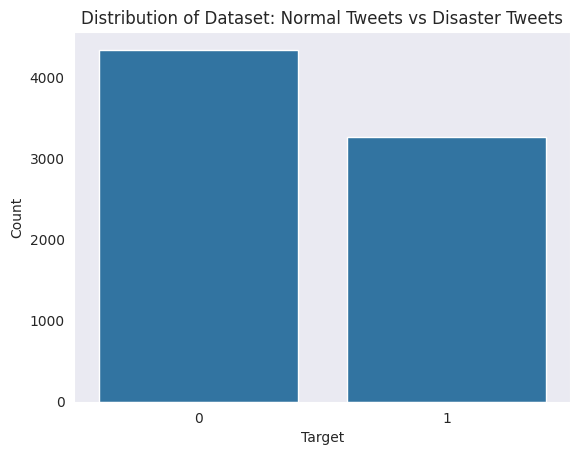

In [ ]:
sns.set_style("dark")
sns.countplot(x = 'target', data = df)
plt.title('Distribution of Dataset: Normal Tweets vs Disaster Tweets')
plt.xlabel('Target')
plt.ylabel('Count')

In [ ]:
# craeteing new column for storing length of reviews
df['length'] = df['text'].apply(len)
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


<Axes: ylabel='Frequency'>

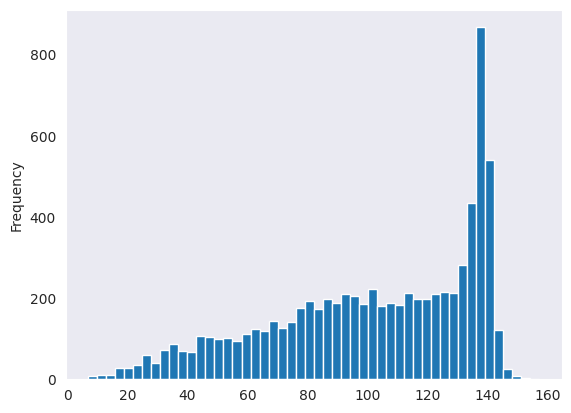

In [ ]:
df['length'].plot(bins=50, kind='hist')

In [ ]:
df.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [ ]:
df[df['length'] == 157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

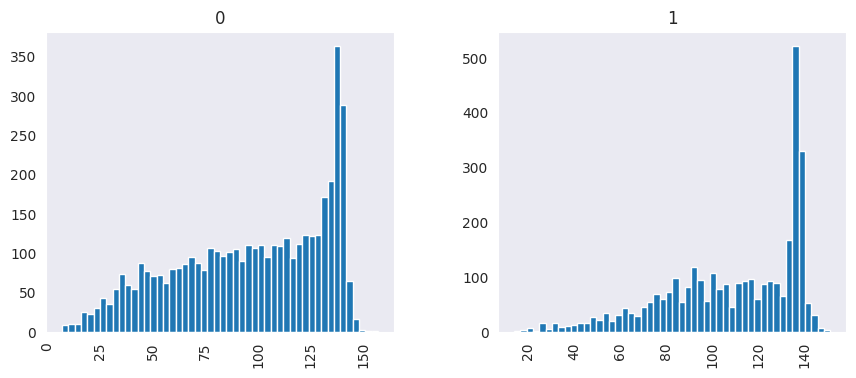

In [ ]:
df.hist(column='length', by='target', bins=50,figsize=(10,4))

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from headline news
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df_1 = df[df['target']==1]
df_0 = df[df['target']==0]
df_1['text']=df_1['text'].apply(remove_stopwords)
df_0['text']=df_0['text'].apply(remove_stopwords)

<ipython-input-10-812a15432658>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['text']=df_1['text'].apply(remove_stopwords)
<ipython-input-10-812a15432658>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['text']=df_0['text'].apply(remove_stopwords)


## Plotting wordcloud of Disaster Tweets

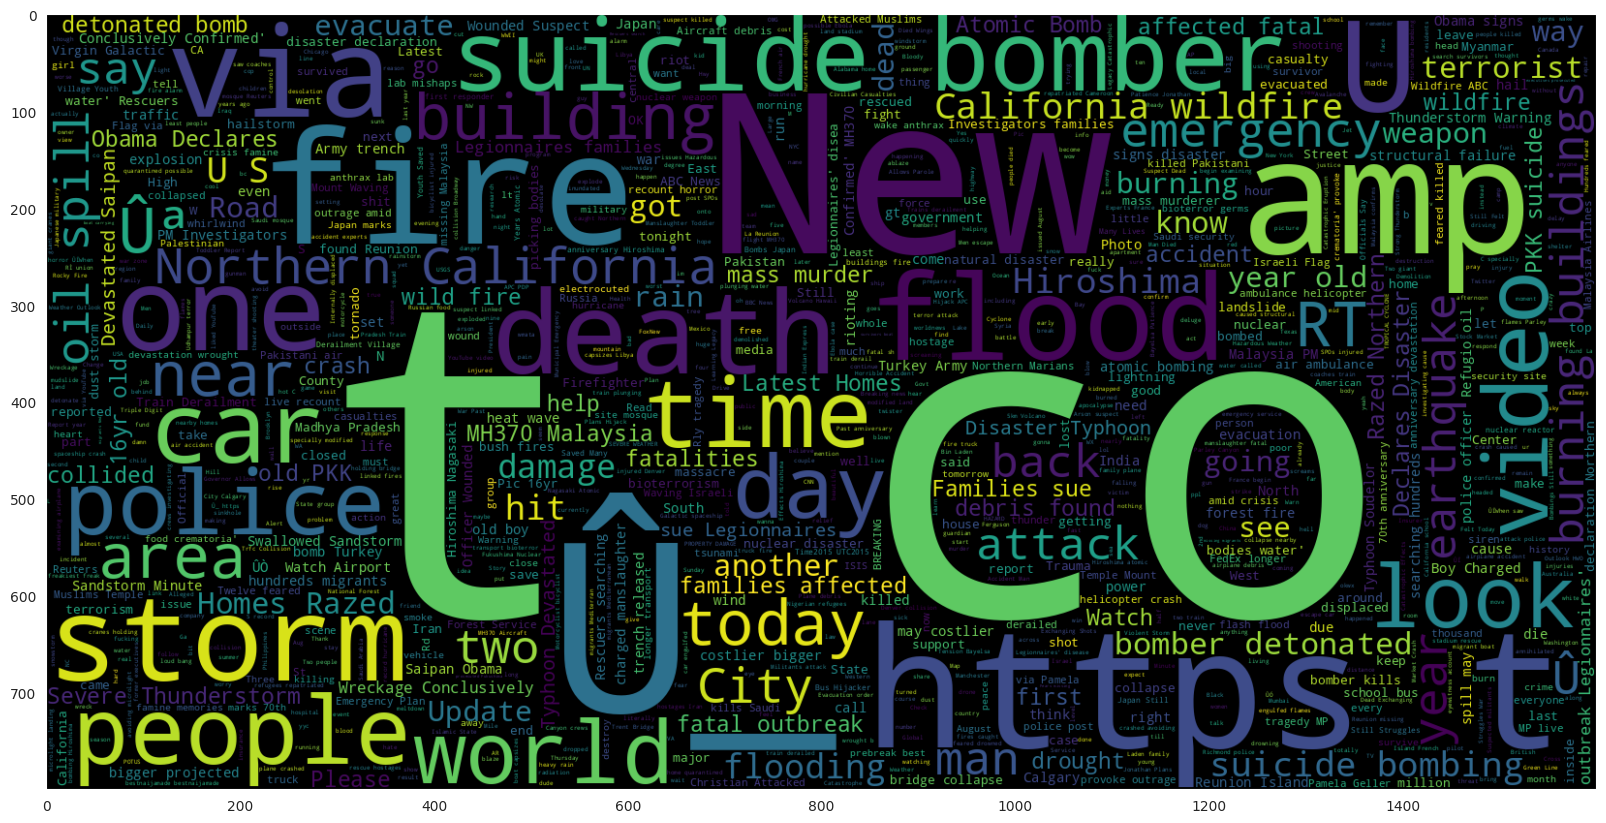

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Disaster tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_1.text))
plt.imshow(wc , interpolation = 'bilinear')


## Plotting wordcloud of Normal Tweets

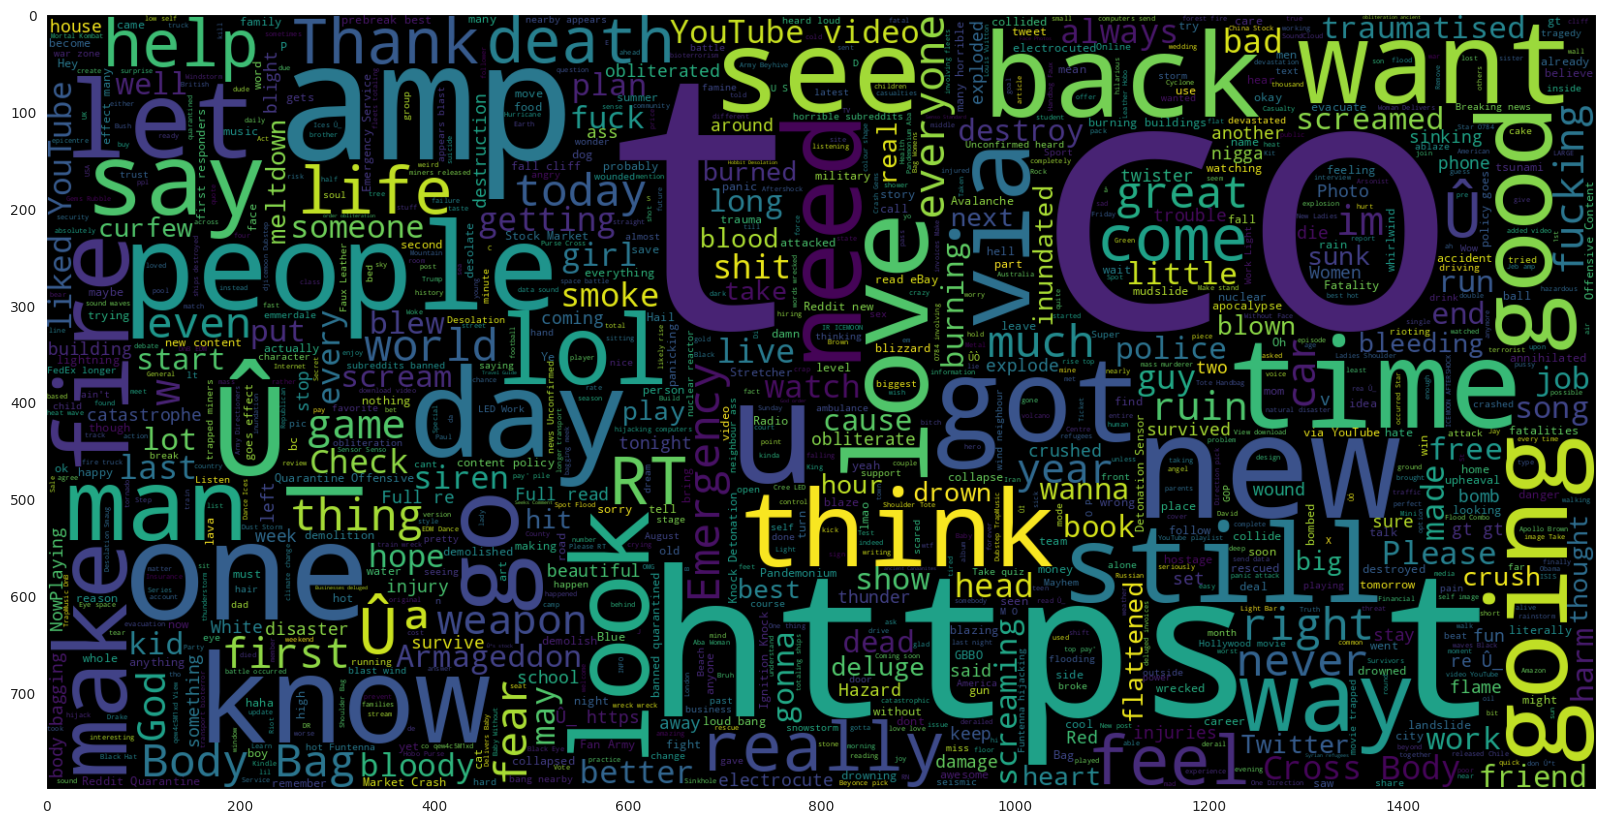

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Normal Tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_0.text))
plt.imshow(wc , interpolation = 'bilinear')

## Data Cleaning and Preparation

In [ ]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
#creating list of possible stopwords from nltk library
stop = stopwords.words('english')

def cleanTweet(txt):
  # lowercaing
    txt = txt.lower()
    # tokenization
    words = nltk.word_tokenize(txt)
  # removing stopwords & mennatizing the words
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in (stop)])
    text = "".join(words)
  # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',text)
    return txt


## Applying Clean Tweet Function on Tweets Text

In [ ]:
df['cleaned_tweets'] = df['text'].apply(cleanTweet)
df.head()

,id,keyword,location,text,target,length,cleaned_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,resident asked shelter place notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfire evacuation or...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire ...


## Creating Feature & Target Variables

In [ ]:
y = df.target
X=df.cleaned_tweets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

## TF-IDF Vectorizer - Bi-Gram

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Multinomial Naive Bayes

In [ ]:
## Model Fitting
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)

MultinomialNB()

## 10-Fold Cross Validation

In [ ]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb2 = cross_val_score(estimator = mnb_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_mnb2.mean()

0.7922824302134648

## Model Prediction Test set

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.7338


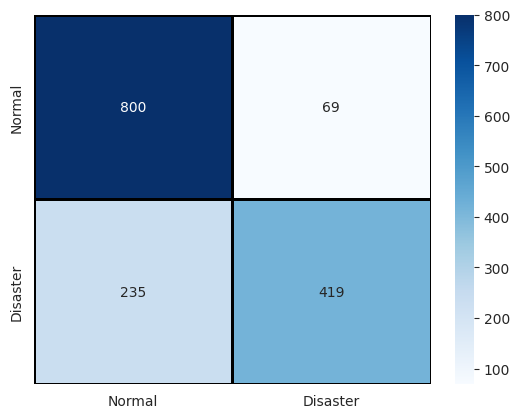

In [ ]:
pred_mnb2 = mnb_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_mnb2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)

acc= accuracy_score(y_test, pred_mnb2)

prec = precision_score(y_test, pred_mnb2)
rec = recall_score(y_test, pred_mnb2)
f1 = f1_score(y_test, pred_mnb2)


model_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])

model_results

## Passive Aggressive Classifier

In [ ]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)

PassiveAggressiveClassifier()

## 10-Fold Cross Validation

In [ ]:

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass2 = cross_val_score(estimator = pass_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_pass2.mean()

0.7870279146141214

## Model Prediction

<ipython-input-23-619f0658fdbf>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = model_results.append(results, ignore_index = True)


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.784636,0.740413,0.767584,0.797468,0.753754


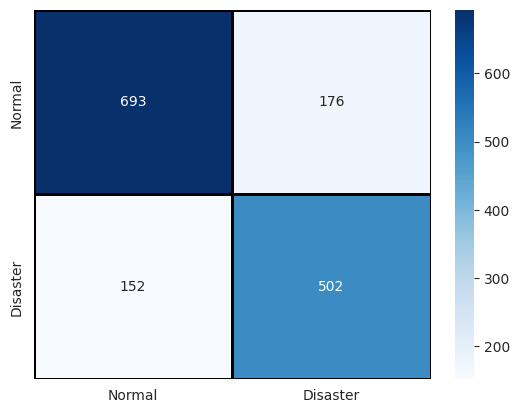

In [ ]:
pred_pass2 = pass_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_pass2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
acc = accuracy_score(y_test, pred_pass2)
prec = precision_score(y_test, pred_pass2)
rec = recall_score(y_test, pred_pass2)
f1 = f1_score(y_test, pred_pass2)

results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = model_results.append(results, ignore_index = True)
results

## Support Vector Machine

In [ ]:
sv_model = SVC()
sv_model.fit(tfidf_train_2,y_train)

SVC()

## 10-Fold Cross Validation

In [ ]:
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_SVM2 = cross_val_score(estimator = sv_model, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_SVM2.mean()

0.7668308702791462

## Model Prediction

<ipython-input-26-bd9c1c03ea11>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results2, ignore_index = True)


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.784636,0.740413,0.767584,0.797468,0.753754
2,Support Vector Classifier - TFIDF-Bigram,0.802364,0.834915,0.672783,0.899885,0.745131


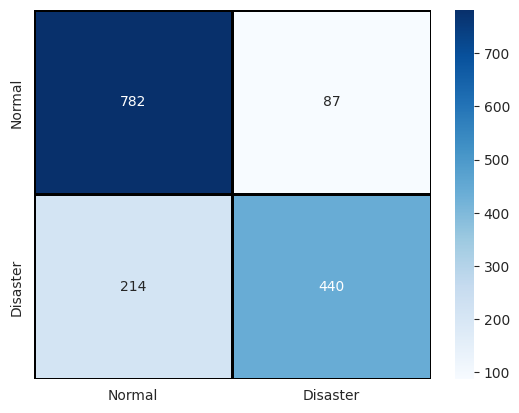

In [ ]:
pred_SVM2 = sv_model.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_SVM2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
acc = accuracy_score(y_test, pred_SVM2)
prec = precision_score(y_test, pred_SVM2)
rec = recall_score(y_test, pred_SVM2)
f1 = f1_score(y_test, pred_SVM2)

results2 =pd.DataFrame([['Support Vector Classifier - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(results2, ignore_index = True)
results

## TF-IDF Vectorizer - Tri Gram

In [ ]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer_3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer_3.transform(X_test)

## Multinomial Naive Bayes - Tri Gram

In [ ]:
mnb_tf3 = MultinomialNB()
mnb_tf3.fit(tfidf_train_3, y_train)

MultinomialNB()

## 10-fold cross validation

In [ ]:
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb3 = cross_val_score(estimator = mnb_tf, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_mnb3.mean()

0.7845648604269294

## Model Prediction

<ipython-input-30-a36256bfc2e1>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(mod_results, ignore_index = True)


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.784636,0.740413,0.767584,0.797468,0.753754
2,Support Vector Classifier - TFIDF-Bigram,0.802364,0.834915,0.672783,0.899885,0.745131
3,Multinomial Naive Bayes - TFIDF-Trigram,0.798424,0.866808,0.626911,0.927503,0.727595


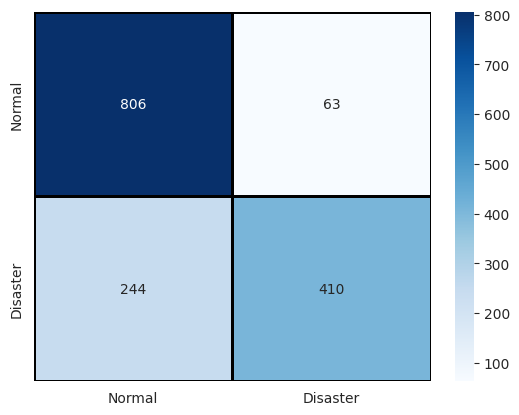

In [ ]:
pred_mnb3 = mnb_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_mnb3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
acc = accuracy_score(y_test, pred_mnb3)
prec = precision_score(y_test, pred_mnb3)
rec = recall_score(y_test, pred_mnb3)
f1 = f1_score(y_test, pred_mnb3)

mod_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(mod_results, ignore_index = True)
results

## Passive Aggressive Classifier - Tri Gram

In [ ]:
pass_tf3 = PassiveAggressiveClassifier()
pass_tf3.fit(tfidf_train_3, y_train)

## cross validation
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass3 = cross_val_score(estimator = pass_tf3, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_pass3.mean()

0.7916256157635468

<ipython-input-32-e668333d8c28>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(mod1_results, ignore_index = True)


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.784636,0.740413,0.767584,0.797468,0.753754
2,Support Vector Classifier - TFIDF-Bigram,0.802364,0.834915,0.672783,0.899885,0.745131
3,Multinomial Naive Bayes - TFIDF-Trigram,0.798424,0.866808,0.626911,0.927503,0.727595
4,Passive Aggressive Classifier - TFIDF-Trigram,0.784636,0.743284,0.761468,0.802071,0.752266


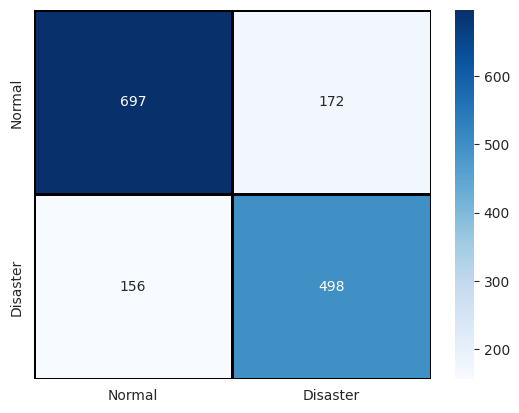

In [ ]:
pred_pass3 = pass_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_pass3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
acc = accuracy_score(y_test, pred_pass3)
prec = precision_score(y_test, pred_pass3)
rec = recall_score(y_test, pred_pass3)
f1 = f1_score(y_test, pred_pass3)

mod1_results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(mod1_results, ignore_index = True)
results

## Support Vector Machine - Bigram

In [ ]:
sv_model3 = SVC()
sv_model3.fit(tfidf_train_3, y_train)

## cross validation
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_SVM3 = cross_val_score(estimator = sv_model3, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_SVM3.mean()

0.7417077175697865

<ipython-input-34-873f494105cd>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(mod2_results, ignore_index = True)
<ipython-input-34-873f494105cd>:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if s.dtype == np.object:


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.784636,0.740413,0.767584,0.797468,0.753754
2,Support Vector Classifier - TFIDF-Bigram,0.802364,0.834915,0.672783,0.899885,0.745131
3,Multinomial Naive Bayes - TFIDF-Trigram,0.798424,0.866808,0.626911,0.927503,0.727595
4,Passive Aggressive Classifier - TFIDF-Trigram,0.784636,0.743284,0.761468,0.802071,0.752266
5,Support Vector Classifier - TFIDF-Trigram,0.794485,0.827255,0.659021,0.896433,0.733617


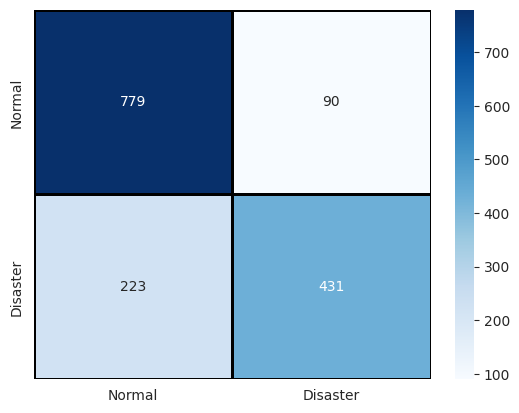

In [ ]:
pred_SVM3 = sv_model3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_SVM3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
acc = accuracy_score(y_test, pred_SVM3)
prec = precision_score(y_test, pred_SVM3)
rec = recall_score(y_test, pred_SVM3)
f1 = f1_score(y_test, pred_SVM3)

mod2_results =pd.DataFrame([['Support Vector Classifier - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(mod2_results, ignore_index = True)
results

def highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: lightgreen' if cell else '' for cell in is_max]
results.style.apply(highlight_max)

In [ ]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb2 = cross_val_score(estimator = mnb_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)

acc_pass2 = cross_val_score(estimator = pass_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)

acc_SVM2 = cross_val_score(estimator = sv_model, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)

acc_mnb3 = cross_val_score(estimator = mnb_tf3, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)

acc_pass3 = cross_val_score(estimator = pass_tf3, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)

acc_SVM3 = cross_val_score(estimator = sv_model3, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)

# compare the average 10-fold cross-validation accuracy
crossdict = {
                'MNB-Bigram': acc_mnb2.mean(),

                'PassiveAggressive-Bigram':acc_pass2.mean(),

                'SupportVectorMachine - Bigram': acc_SVM2.mean(),

                'MNB-Trigram': acc_mnb3.mean(),

                'PassiveAggressive-Trigram': acc_pass3.mean(),

                'SupportVectorMachine - Trigram': acc_SVM3.mean() }

cross_df = pd.DataFrame(crossdict.items(), columns=['Model', 'Cross-val accuracy'])
cross_df = cross_df.sort_values(by=['Cross-val accuracy'], ascending=False)
cross_df

,Model,Cross-val accuracy
4,PassiveAggressive-Trigram,0.792775
0,MNB-Bigram,0.792282
1,PassiveAggressive-Bigram,0.785386
3,MNB-Trigram,0.784565
2,SupportVectorMachine - Bigram,0.766831
5,SupportVectorMachine - Trigram,0.766831


## Most Informative Features

In [ ]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472

    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [ ]:
most_informative_feature_for_binary_classification(tfidf_vectorizer_3, pass_tf3, n=10)

0 -2.1273541397223417 let
0 -2.0693670687919505 bag
0 -1.9484221414862932 love
0 -1.9243267081333055 suicide bomb
0 -1.8963486166237322 curfew
0 -1.8900759160405507 new
0 -1.8131467839826407 flattened
0 -1.7982011939800138 traumatised
0 -1.7837715239252445 hrqcjdovjz
0 -1.7837715239252445 http hrqcjdovjz

1 3.8993062019694227 hiroshima
1 3.8871482487669464 http
1 3.4846127862076406 california
1 3.0824505373847653 building
1 3.073705420211446 bombing
1 3.056944527816007 wildfire
1 2.866962451335046 forest
1 2.856921379185404 flood
1 2.769268021138335 train
1 2.767294036738093 killed


## Sample prediction

In [ ]:
sentences = [
    "Son is a volcano",
    "tung fuck his cat and die",
    "Review of SpaceX achievements in 2023 and plans for 2024",
  "Just happened a terrible car crash",
    "Heard about #earthquake is different cities, stay safe everyone.",
    "No I don't like cold!",
    "@RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated?"
  ]

tfidf_trigram = tfidf_vectorizer_3.transform(sentences)


predictions = pass_tf3.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label==1:
        target="Disaster Tweet"
        print("text:", text, "\nClass:", target)
        print()
    else:
        target="Normal Tweet"
        print("text:", text, "\nClass:", target)
        print()

text: Son is a volcano 
Class: Disaster Tweet

text: tung fuck his cat and die 
Class: Normal Tweet

text: Review of SpaceX achievements in 2023 and plans for 2024 
Class: Normal Tweet

text: Just happened a terrible car crash 
Class: Disaster Tweet

text: Heard about #earthquake is different cities, stay safe everyone. 
Class: Disaster Tweet

text: No I don't like cold! 
Class: Normal Tweet

text: @RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated? 
Class: Normal Tweet

